# Quick Overview

This notebook provides a quick example of how to start using the `spectral_recovery` package. More detailed examples will soon become available in the [User Guide](https://people-er.github.io/Spectral-Recovery/about/).

## Installation

The tool can be installed using the package manager pip. The package is in <ins>pre-release state</ins> so we must specify the version number `=0.1.0b1` in order to download.

In [ ]:
! pip install spectral-recovery==0.1.1b1

Once the tool is installed, you can import the relevant modules:

In [2]:
from spectral_recovery.restoration import RestorationArea
from spectral_recovery.io import raster

## Defining a RestorationArea

To begin, we must create a `RestorationArea` object. This object holds and coordinates all the information necessary to compute recovery metrics for an area that has experienced disturbance and/or restoration. The following section briefly describes the input parameters but for more in-depth information, please see the [Spectral Recovery Tool](https://people-er.github.io/Spectral-Recovery/about/#2-the-spectral-recovery-tool) section in the User Guide.

### Input Parameters

| Name  | Type  | Description  |
|---|:---:|---|
| **restoration_polygon**  | geopandas.GeoDataFrame  | The spatial deliniation of the restoration event, i.e where disturance/restoration has occured.  |   
|  **restoration_start** | datetime | The year the disturbance began.  |   
| **disturbance_start**  | datetime  |  The year the restoration event began. |  
|  **reference_polygon** | geopandas.GeoDataFrame  | The spatial deliniation of the reference systems.  |   
|  **reference_years** | list of datetime  | The year or range of years to use for determining a recovery target.  |   
|  **composite_stack** | xarray.DataArray  | The timeseries of annual composites for computing recovery metrics.   |  

### Prepping Inputs

#### Polygons

Start by reading in a restoration polygon into a geopandas.GeoDataFrame.

Text(0.5, 1.0, 'Test restoration polygon')

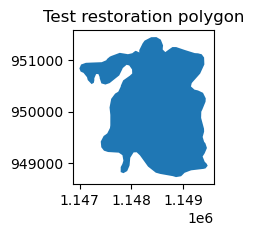

In [3]:
import geopandas as gpd

restoration_poly = gpd.read_file("test_data/test_restoration_polygon.gpkg")
restoration_poly.plot(figsize=(2, 2)).set_title("Test restoration polygon")

#### Annual Composites

Next, read in your set of annual composites. To do this use the `read_and_stack_tifs` method provided in the package's `io.raster` module. The methods requires that you either provide a path to a directory containing all of your annual composites, or you provide a list of paths to each individual composite. Each composite:

1. _must_ be named after the year of which they are a composite, e.g for a composite of 2014 the file must be named `2014.tif`
2. _must_ have the bands named by their common names/acronyms

Each composite can contain multiple bands but each band must be present in all composites.

The set of annual composites that we'll be using in this notebook was created using the [GEE BAP tool](https://github.com/saveriofrancini/bap).

In [4]:
composite_stack = raster.read_and_stack_tifs("test_data/annual_composites/test_baps")
composite_stack

<xarray.DataArray (band: 6, time: 16, y: 1049, x: 703)>
dask.array<getitem, shape=(6, 16, 1049, 703), dtype=int16, chunksize=(1, 1, 1049, 703), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) object BLUE GREEN RED NIR SWIR1 SWIR2
  * x            (x) float64 1.147e+06 1.147e+06 ... 1.168e+06 1.168e+06
  * y            (y) float64 9.802e+05 9.801e+05 ... 9.488e+05 9.487e+05
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2007-01-01 2008-01-01 ... 2022-01-01
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        2802
    STATISTICS_MEAN:           237.11871201345
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         186.49794795854
    STATISTICS_VALID_PERCENT:  100
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('blue', 'green', 'red', 'nir', 'swir1', 'swir2')

Compute indices using the `satts` accessor, you can choose from the following indices: 'NDVI', 'NBR','GNDVI', 'EVI', 'AVI', 'SAVI','NDWI','TCG','TCW','TCB','SR','NDMI','GCI','NDII'

In [5]:
from spectral_recovery.enums import Index

indices_stack = composite_stack.satts.indices([Index.nbr, Index.ndmi, Index.gndvi])
indices_stack

<xarray.DataArray (band: 3, time: 16, y: 1049, x: 703)>
dask.array<concatenate, shape=(3, 16, 1049, 703), dtype=float64, chunksize=(1, 1, 1049, 703), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 1.147e+06 1.147e+06 ... 1.168e+06 1.168e+06
  * y            (y) float64 9.802e+05 9.801e+05 ... 9.488e+05 9.487e+05
  * time         (time) datetime64[ns] 2007-01-01 2008-01-01 ... 2022-01-01
    spatial_ref  int64 0
  * band         (band) object NBR NDMI GNDVI

#### Dates/Years

Finally, define the years we need for a restoration area: disturbance event start year, restoration event start year, and reference year(s).

In [6]:
import pandas as pd

disturbance_start = pd.to_datetime("2014") # the disturbance started in this year
restoration_start = pd.to_datetime("2015") # the restoration started in this year (and disturbance ended in this year)
reference_years = [pd.to_datetime("2012"), pd.to_datetime("2013")] # derive recovery target from the range of these years

### Creating a RestorationArea

Now that we've prepped our input, we can create a RestorationArea and are one step closer to computing recovery metrics.

In [7]:
ra = RestorationArea(
    restoration_polygon=restoration_poly,
    reference_polygon=restoration_poly,
    disturbance_start=disturbance_start, 
    restoration_start=restoration_start,
    reference_years=reference_years,
    composite_stack=indices_stack,
)
# ta-da! 

Our RestorationArea `ra` derives a recovery target from a historical approach, over the provided reference years. We can view the result by investigating the `ra.reference_system` attribute.

In [8]:
ra.reference_system.recovery_target()["recovery_target"].compute()

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.DataArray (band: 3)>
array([0.46761892, 0.17781728, 0.6523905 ])
Coordinates:
  * band         (band) object NBR NDMI GNDVI
    spatial_ref  int64 0

## Computing Recovery Metrics

In [9]:
import matplotlib.pyplot as plt

Now that we have our RestorationArea defined, computing recovery metrics is as simple as calling the desired metric method!

### Y2R

In [11]:
y2r = ra.Y2R()

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/reductions.py:1073: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)


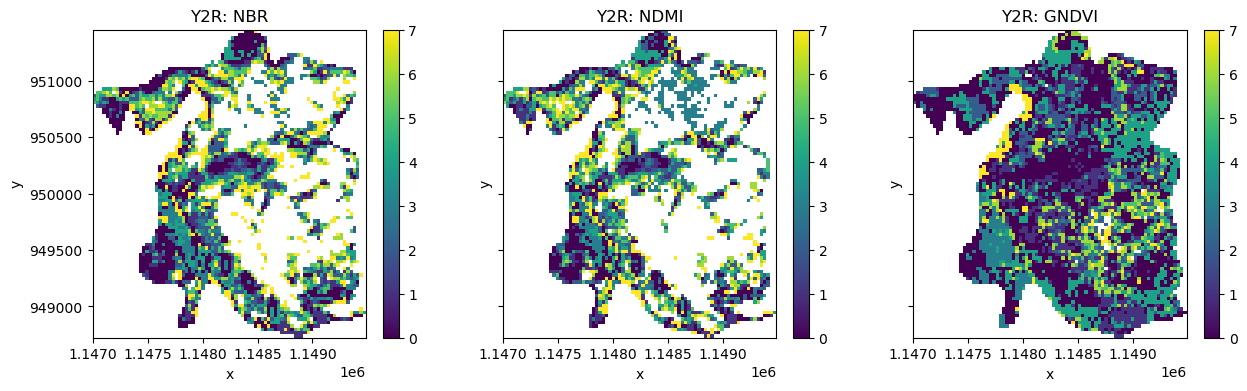

In [12]:
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=[15, 4])
for i in range(3):
    y2r[0,i,:,:].plot(ax=axes[i])
    axes[i].set_title(f"Y2R: {y2r['band'].values[i]}")

### R80P

In [13]:
r80p = ra.R80P()

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


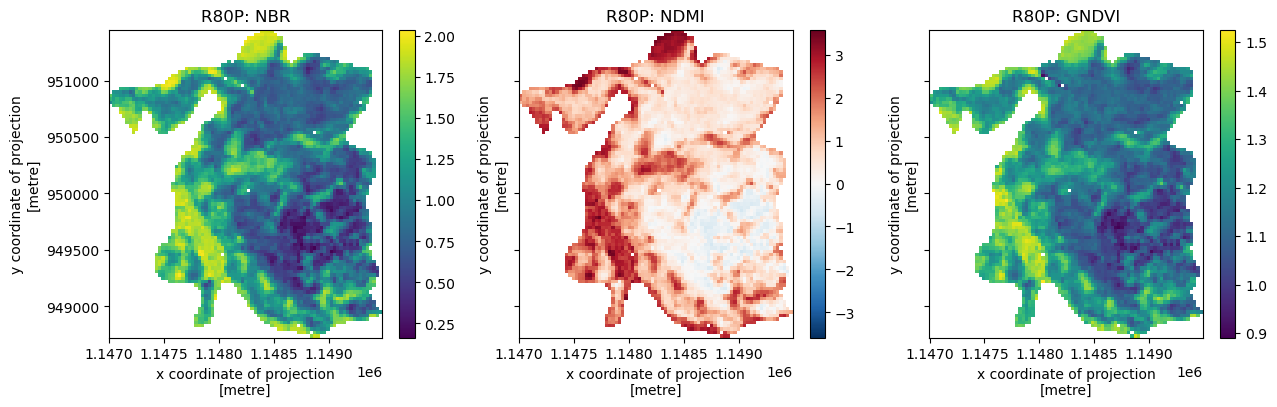

In [14]:
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=[15, 4])
for i in range(3):
    r80p[0,i,:,:].plot(ax=axes[i])
    axes[i].set_title(f"R80P: {y2r['band'].values[i]}")

### YrYr

In [15]:
yryr = ra.YrYr()

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


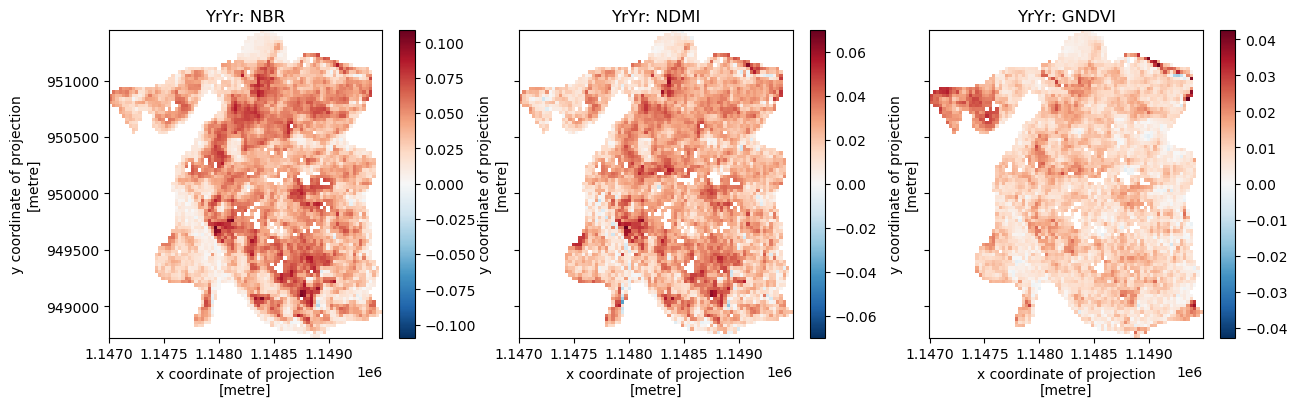

In [16]:
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=[15, 4])
for i in range(3):
    yryr[0,i,:,:].plot(ax=axes[i])
    axes[i].set_title(f"YrYr: {y2r['band'].values[i]}")

### dNBR

In [18]:
dNBR = ra.dNBR()

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


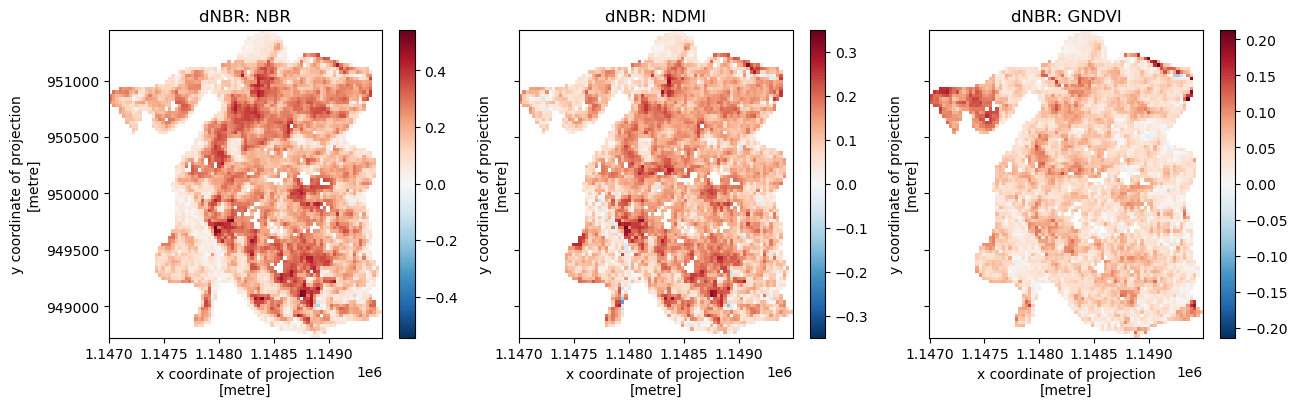

In [19]:
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=[15, 4])
for i in range(3):
    dNBR[0,i,:,:].plot(ax=axes[i])
    axes[i].set_title(f"dNBR: {y2r['band'].values[i]}")